In [ ]:
#Finding the effects of pitch speed and break on called and swinging strikes

In [1]:
#allow output from every line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#importing packages
import pandas as pd
import numpy as np
from pybaseball import lahman
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
from pybaseball import statcast

In [3]:
#Importing Statcast Data from 2023
data23 = statcast(start_dt='2023-03-30', end_dt='2023-11-01')
#saving as CSV for easier future access
data23.to_csv("FinalData/data23.csv")

This is a large query, it may take a moment to complete


/Users/jason.weinberg/anaconda3/lib/python3.11/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|█████████████████████████████████████████| 217/217 [01:59<00:00,  1.82it/s]


In [3]:
### filtering out non-pitch values listed below:
### AB Automatic Ball, IN Intentional Ball, PO Pitch out, nan values
data23 = pd.read_csv("FinalData/data23.csv")
data23 = data23[(data23['pitch_type'] != 'AB') & 
                              (data23['pitch_type'] != 'IN') & 
                              (data23['pitch_type'] != 'PO')]

In [287]:
#sorting pitches by type
pitches = data23.pitch_type
#finding unique pitch types
np.unique(pitches)

array(['CH', 'CS', 'CU', 'EP', 'FA', 'FC', 'FF', 'FO', 'FS', 'KC', 'KN',
       'SC', 'SI', 'SL', 'ST', 'SV', 'nan'], dtype=object)

In [288]:
#prepping data: using https://www.daktronics.com/en-us/support/kb/DD3312647 to determine initials used in statcast 
##using https://www.mlb.com/glossary/pitch-types to determine fast and off-speed pitches
###pulling out pitch type, reuslt, and release speed
speeds = data23.release_speed
results = data23.description

#breaking the pitches into bins for 100 mph or more, 95-99, 90-94, and 85-89, 80-84, 75-79, and 70-74 mph
one_hundred_plus = speeds >= 100
ninetyfive_to_99 = (speeds >= 95) & (speeds <= 99.9)
ninety_to_94 = (speeds >= 90) & (speeds <= 94.9)
eightyfive_to_89 = (speeds >= 85) & (speeds <= 89.9)
eighty_to_84 = (speeds >= 80) & (speeds <= 84.9)
seventyfive_to_79 = (speeds >= 75) & (speeds <= 79.9)
seventy_to_74 = (speeds >= 70) & (speeds <= 74.9)
below_70 = (speeds <= 69.9)

In [289]:
#adding binned data into the original data frame
speed_bins = ["100+ mph", "95-99 mph", "90-94 mph", "85-89 mph", "80-84 mph", "75-79 mph", "70-74 mph"]
data23['speed_bin'] = pd.Series(dtype='object')
data23.loc[one_hundred_plus, 'speed_bin'] = '100+ mph'
data23.loc[ninetyfive_to_99, 'speed_bin'] = '95-99 mph'
data23.loc[ninety_to_94, 'speed_bin'] = '90-94 mph'
data23.loc[eightyfive_to_89, 'speed_bin'] = '85-89 mph'
data23.loc[eighty_to_84, 'speed_bin'] = '80-84 mph'
data23.loc[seventyfive_to_79, 'speed_bin'] = '75-79 mph'
data23.loc[seventy_to_74, 'speed_bin'] = '70-74 mph'
data23.loc[below_70, 'speed_bin'] = '<70'

In [290]:
#finding the length of each value to see how many pitches were thrown in each bin
print(f"There were", len(speeds[one_hundred_plus]), "pitches thrown over 100 MPH in 2023")
print(f"There were", len(speeds[ninetyfive_to_99]), "pitches thrown between 95 and 99 MPH in 2023")
print(f"There were", len(speeds[ninety_to_94]), "pitches thrown between 90 and 94 MPH in 2023")
print(f"There were", len(speeds[eightyfive_to_89]), "pitches thrown between 85 and 89 MPH in 2023")
print(f"There were", len(speeds[eighty_to_84]), "pitches thrown between 80 and 84 MPH in 2023")
print(f"There were", len(speeds[seventyfive_to_79]), "pitches thrown between 75 and 79 MPH in 2023")
print(f"There were", len(speeds[seventy_to_74]), "pitches thrown between 70 and 74 MPH in 2023")
print(f"There were", len(speeds[below_70]), "pitches thrown below 70 MPH in 2023")

There were 4018 pitches thrown over 100 MPH in 2023
There were 121111 pitches thrown between 95 and 99 MPH in 2023
There were 235932 pitches thrown between 90 and 94 MPH in 2023
There were 173820 pitches thrown between 85 and 89 MPH in 2023
There were 140463 pitches thrown between 80 and 84 MPH in 2023
There were 43294 pitches thrown between 75 and 79 MPH in 2023
There were 8888 pitches thrown between 70 and 74 MPH in 2023
There were 1931 pitches thrown below 70 MPH in 2023


In [291]:
#Finding how many non-contact strikes were thrown
##Using non-contact to find the relationship between speed on strikes called and swung and missed on
non_contact_strikes = data23[data23['description'].isin(["called_strike", "swinging_strike"])]
len(non_contact_strikes)
print(f"Out of", len(pitches),"total pitches in 2023,", len(non_contact_strikes), "were swinging or called strikes")
print(f"That is a percentage of", (len(non_contact_strikes) / len(pitches) * 100), "%")

197412

Out of 729727 total pitches in 2023, 197412 were swinging or called strikes
That is a percentage of 27.052856753278963 %


In [292]:
#running a for loop to find the amount of strikes in each speed bin
##storing the results in results_df
results_df = pd.DataFrame(columns=non_contact_strikes['description'].unique())
#Iterate through speed bins
for speed_bin in speed_bins:
    speed_bin_data = non_contact_strikes[non_contact_strikes['speed_bin'] == speed_bin]
    #count amounts for each description in the current speed bin
    counts = speed_bin_data['description'].value_counts()
    #using .loc to add the counts to the results DataFrame, filling NaN values with 0 for future counting purposes
    results_df.loc[speed_bin] = counts
    results_df = results_df.fillna(0)
#adding in last bin for below 70 MPH
below_70_data = non_contact_strikes[non_contact_strikes['speed_bin'] == '<70']
counts_below_70 = below_70_data['description'].value_counts()
results_df.loc['<70'] = counts_below_70
results_df

,called_strike,swinging_strike
100+ mph,587,562
95-99 mph,20408,11781
90-94 mph,43912,19058
85-89 mph,24571,22227
80-84 mph,20107,18474
75-79 mph,8145,4501
70-74 mph,1722,899
<70,304,81


In [293]:
#counting the total strikes from each speed bin
results_df['total_count'] = results_df['called_strike'] + results_df['swinging_strike']
borda_values = results_df.total_count.sort_values()
results_df

,called_strike,swinging_strike,total_count
100+ mph,587,562,1149
95-99 mph,20408,11781,32189
90-94 mph,43912,19058,62970
85-89 mph,24571,22227,46798
80-84 mph,20107,18474,38581
75-79 mph,8145,4501,12646
70-74 mph,1722,899,2621
<70,304,81,385


In [294]:
#Counting and Ranking the strikes thrown by each speed bin
results_df['total_ranked'] = results_df['total_count'].rank(ascending=False, method='min')
overall_results_sorted = results_df.sort_values(by='total_ranked')
overall_results_sorted

,called_strike,swinging_strike,total_count,total_ranked
90-94 mph,43912,19058,62970,1.0
85-89 mph,24571,22227,46798,2.0
80-84 mph,20107,18474,38581,3.0
95-99 mph,20408,11781,32189,4.0
75-79 mph,8145,4501,12646,5.0
70-74 mph,1722,899,2621,6.0
100+ mph,587,562,1149,7.0
<70,304,81,385,8.0


In [295]:
#adding percentages of total strikes and pitches
total_non_contact_strikes = len(non_contact_strikes)
total_pitches = len(pitches)
overall_results_sorted['percentage_of_total_strikes'] = (overall_results_sorted['total_count'] / total_non_contact_strikes) * 100
overall_results_sorted

,called_strike,swinging_strike,total_count,total_ranked,percentage_of_total_strikes
90-94 mph,43912,19058,62970,1.0,31.897757
85-89 mph,24571,22227,46798,2.0,23.705752
80-84 mph,20107,18474,38581,3.0,19.543391
95-99 mph,20408,11781,32189,4.0,16.305493
75-79 mph,8145,4501,12646,5.0,6.405892
70-74 mph,1722,899,2621,6.0,1.327680
100+ mph,587,562,1149,7.0,0.582031
<70,304,81,385,8.0,0.195024


In [296]:
#adding total pitches in each bin to my dataframe to get a better look at percentages
##grouping data by speed bin, changing index to reflect the total amount of pitches in each bin
total_pitches_by_bin = data23.groupby('speed_bin').size().reset_index(name='total_pitches')
bins_total_pitches_thrown = total_pitches_by_bin.set_index('speed_bin')
bins_total_pitches_thrown

,total_pitches
speed_bin,
100+ mph,4018
70-74 mph,8888
75-79 mph,43294
80-84 mph,140463
85-89 mph,173820
90-94 mph,235932
95-99 mph,121111
<70,1931


In [297]:
#merging in data using pd.merge and a left join
overall_results_sorted = pd.merge(overall_results_sorted, bins_total_pitches_thrown, left_index=True, right_index=True, how='left')
overall_results_sorted 

,called_strike,swinging_strike,total_count,total_ranked,percentage_of_total_strikes,total_pitches
90-94 mph,43912,19058,62970,1.0,31.897757,235932
85-89 mph,24571,22227,46798,2.0,23.705752,173820
80-84 mph,20107,18474,38581,3.0,19.543391,140463
95-99 mph,20408,11781,32189,4.0,16.305493,121111
75-79 mph,8145,4501,12646,5.0,6.405892,43294
70-74 mph,1722,899,2621,6.0,1.327680,8888
100+ mph,587,562,1149,7.0,0.582031,4018
<70,304,81,385,8.0,0.195024,1931


In [298]:
overall_results_sorted['strike_to_pitch%'] = ((overall_results_sorted['total_count'] / overall_results_sorted['total_pitches']) * 100)
overall_results_sorted
#storing overall DF into csv
overall_results_sorted.to_csv("FinalData/OverallResultsSorted.csv")
#strike to pitch %: Percentage of strikes thrown by each speed. For example, a pitch thrown over 90-94 MPH has a 
## 26.6% chance to be a called or swinging strike

,called_strike,swinging_strike,total_count,total_ranked,percentage_of_total_strikes,total_pitches,strike_to_pitch%
90-94 mph,43912,19058,62970,1.0,31.897757,235932,26.689894
85-89 mph,24571,22227,46798,2.0,23.705752,173820,26.923254
80-84 mph,20107,18474,38581,3.0,19.543391,140463,27.467020
95-99 mph,20408,11781,32189,4.0,16.305493,121111,26.578098
75-79 mph,8145,4501,12646,5.0,6.405892,43294,29.209590
70-74 mph,1722,899,2621,6.0,1.327680,8888,29.489199
100+ mph,587,562,1149,7.0,0.582031,4018,28.596317
<70,304,81,385,8.0,0.195024,1931,19.937856


<IPython.core.display.Javascript object>


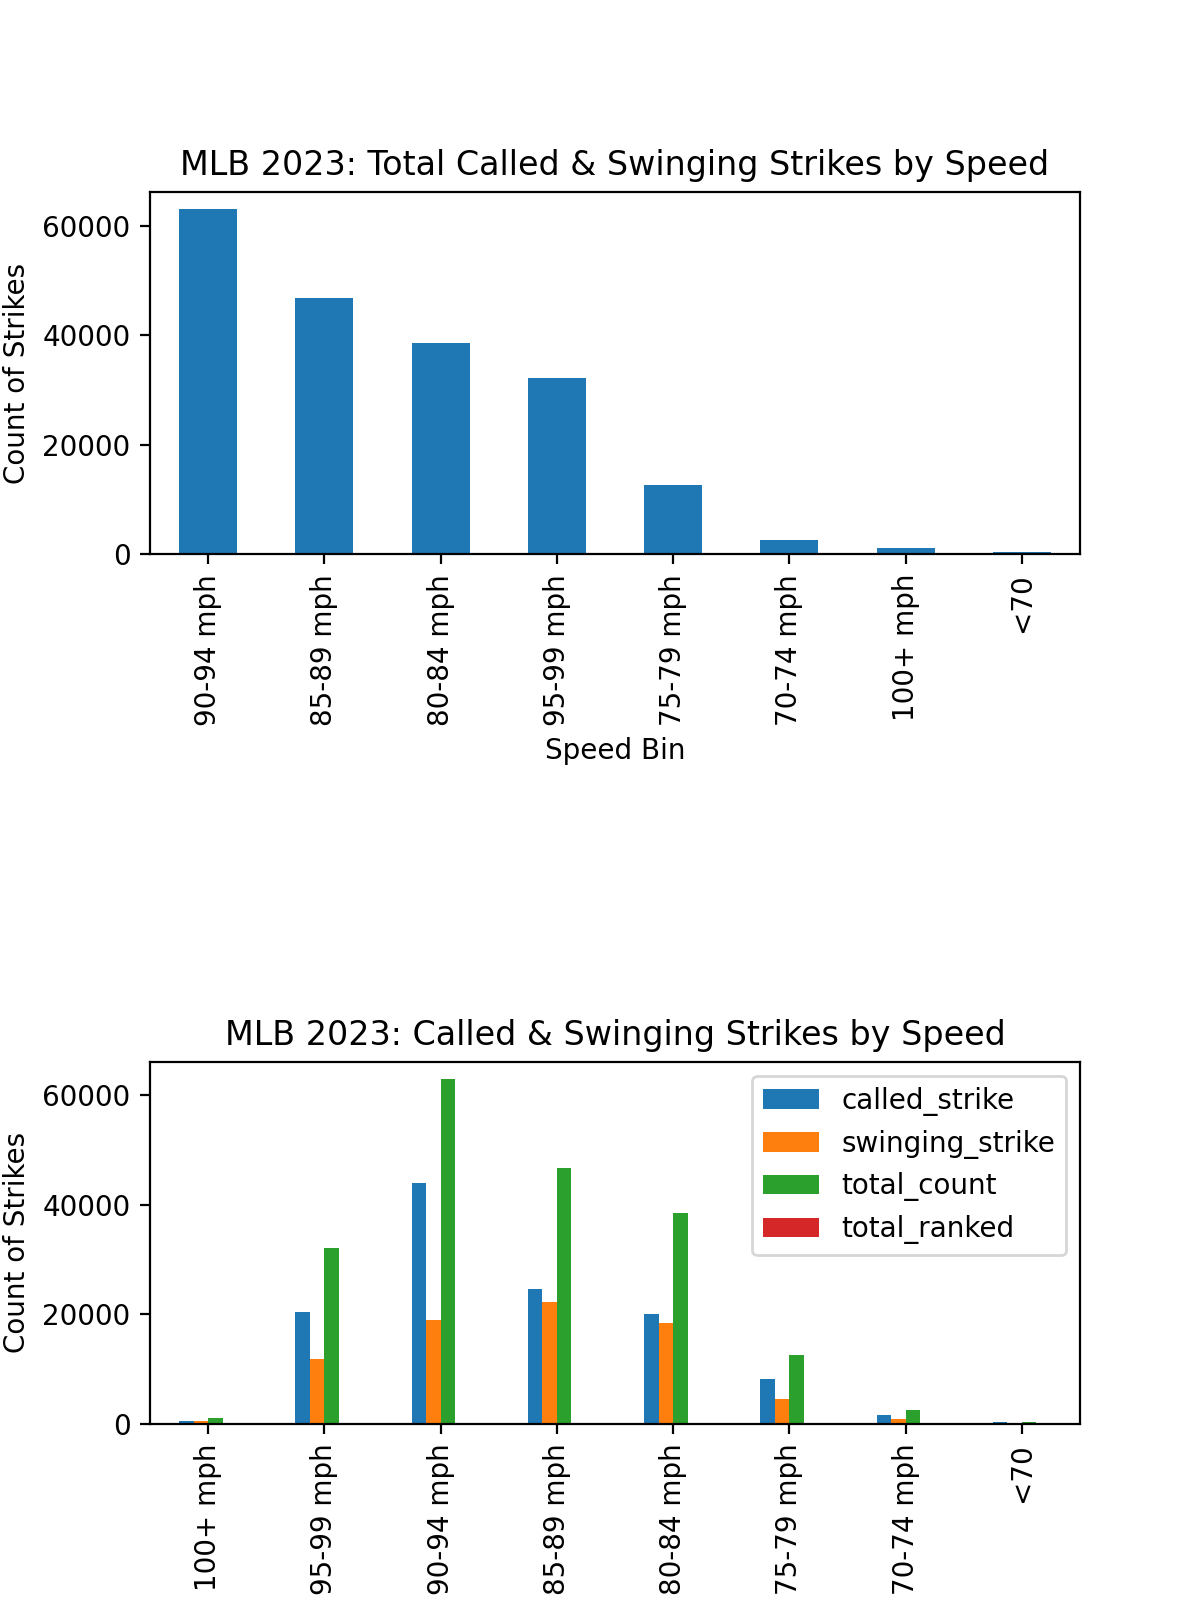

Text(0.5, 0, 'Speed Bin')

Text(0, 0.5, 'Count of Strikes')

Text(0.5, 1.0, 'MLB 2023: Total Called & Swinging Strikes by Speed')

<Axes: >

Text(0, 0.5, 'Count of Strikes')

Text(0.5, 0, 'Speed Bin')

Text(0.5, 1.0, 'MLB 2023: Called & Swinging Strikes by Speed')

In [301]:
data_for_vis_one = overall_results_sorted['total_count']
fig = plt.figure()
ax1 = fig.add_subplot(3, 1, 1)
ax1 = data_for_vis_one.plot.bar(figsize=(6, 8))
ax1.set_xlabel('Speed Bin')
ax1.set_ylabel('Count of Strikes')
ax1.set_title("MLB 2023: Total Called & Swinging Strikes by Speed")
ax2 = fig.add_subplot(3, 1, 3)
results_df.plot.bar(ax=ax2)
ax2.set_ylabel('Count of Strikes')
ax2.set_xlabel('Speed Bin')
ax2.legend(loc='best')
ax2.set_title("MLB 2023: Called & Swinging Strikes by Speed")
fig.savefig("FinalData/visualization1.pdf")

In [302]:
##The top value is displayed as the 90-94 MPH bin, with the second being 85-89 MPH
###The two top speed bins, 95-99 and 100+ are 4th and 8th respectively in terms of their ranking of bins by count

<IPython.core.display.Javascript object>


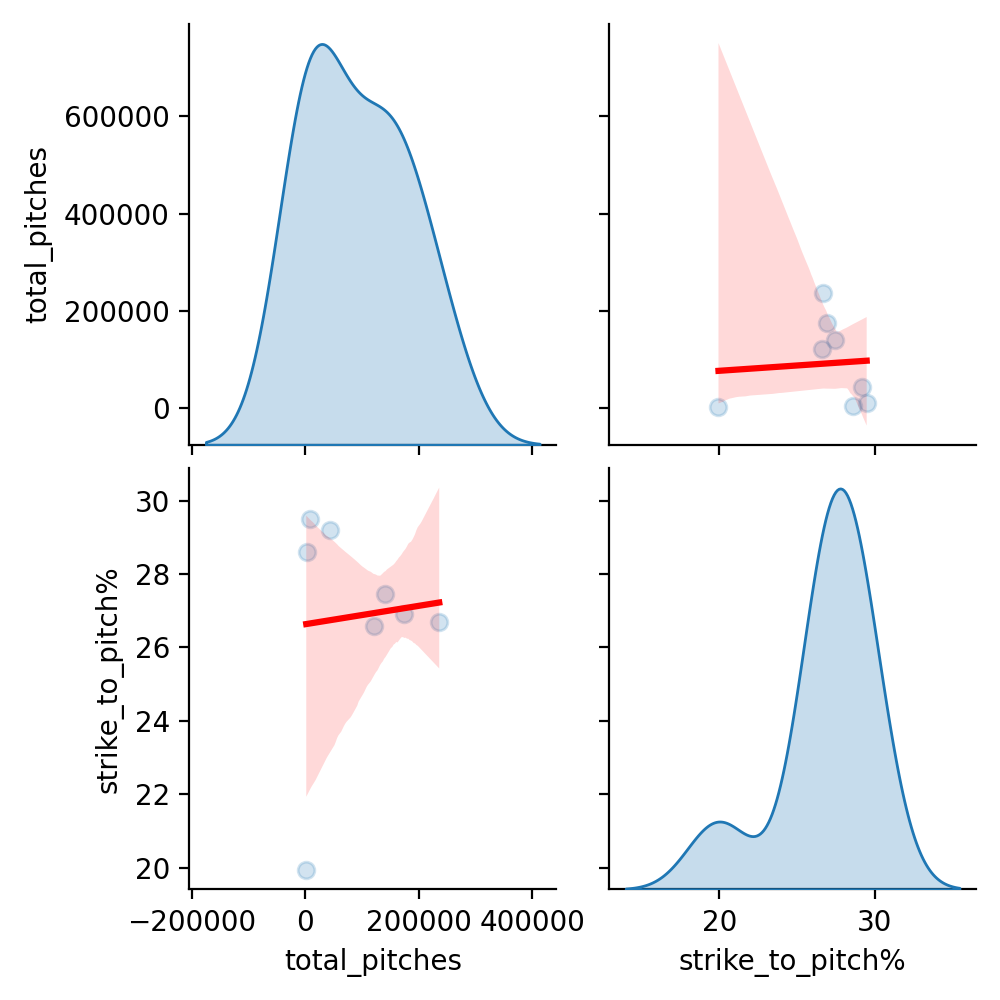

/Users/jason.weinberg/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


In [310]:
selected_data = overall_results_sorted[['total_pitches', 'strike_to_pitch%']]
sns.pairplot(selected_data, diag_kind="kde", kind="reg", 
             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws':{'alpha':0.2}})

In [330]:
#sorting pitches by type
pitches = data23.pitch_type
#finding unique pitch types
np.unique(pitches)
breaking_pitches_bool = np.in1d(pitches,["CU","SL","KN","KC","ST","FO","SC","CS","SV"])
other_pitches_bool = np.in1d(pitches,["FF","CH","EP","FA","FC","SI"])
breaking = data23[breaking_pitches_bool]
others = data23[other_pitches_bool]
len(breaking)
len(others)
print(f"Out of", len(pitches), "total pitches there were", len(breaking), "breaking pitches and", len(others), "non-breaking pitches")

array(['CH', 'CS', 'CU', 'EP', 'FA', 'FC', 'FF', 'FO', 'FS', 'KC', 'KN',
       'SC', 'SI', 'SL', 'ST', 'SV', 'nan'], dtype=object)

228320

485163

Out of 729727 total pitches there were 228320 breaking pitches and 485163 non-breaking pitches
